In [1]:
from tensorflow.keras.datasets import mnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
### load mnist dataset and data preprocessing
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('x_train shape:', x_train.shape)
print('        dtype:', x_train.dtype)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (60000, 28, 28)
        dtype: uint8


In [4]:
### outputs list of NxN patches from an image
def getPatches(image, patch_size, pad_size, stride):
    # find shape of original image and shape of output
    x_img, y_img = image.shape
    x_out = ((x_img - patch_size + 2 * pad_size) // stride) + 1
    y_out = ((y_img - patch_size + 2 * pad_size) // stride) + 1

    # pad original image
    image = np.pad(image, pad_width=pad_size, mode='constant', constant_values=0)

    # find all patches and place into output matrix
    output = np.empty((x_out, y_out, patch_size, patch_size), dtype='uint8')
    
    for x in range(x_out):
        for y in range(y_out):
            x_start = x * stride
            y_start = y * stride
            
            output[x,y] = image[x_start:(x_start + patch_size), y_start:(y_start + patch_size)]

    # reshape output to list
    output = output.reshape(-1, patch_size, patch_size)
    
    return output
    

In [5]:
### set parameters for getPatches function
patch_size = 3
pad_size = 1
stride = 1

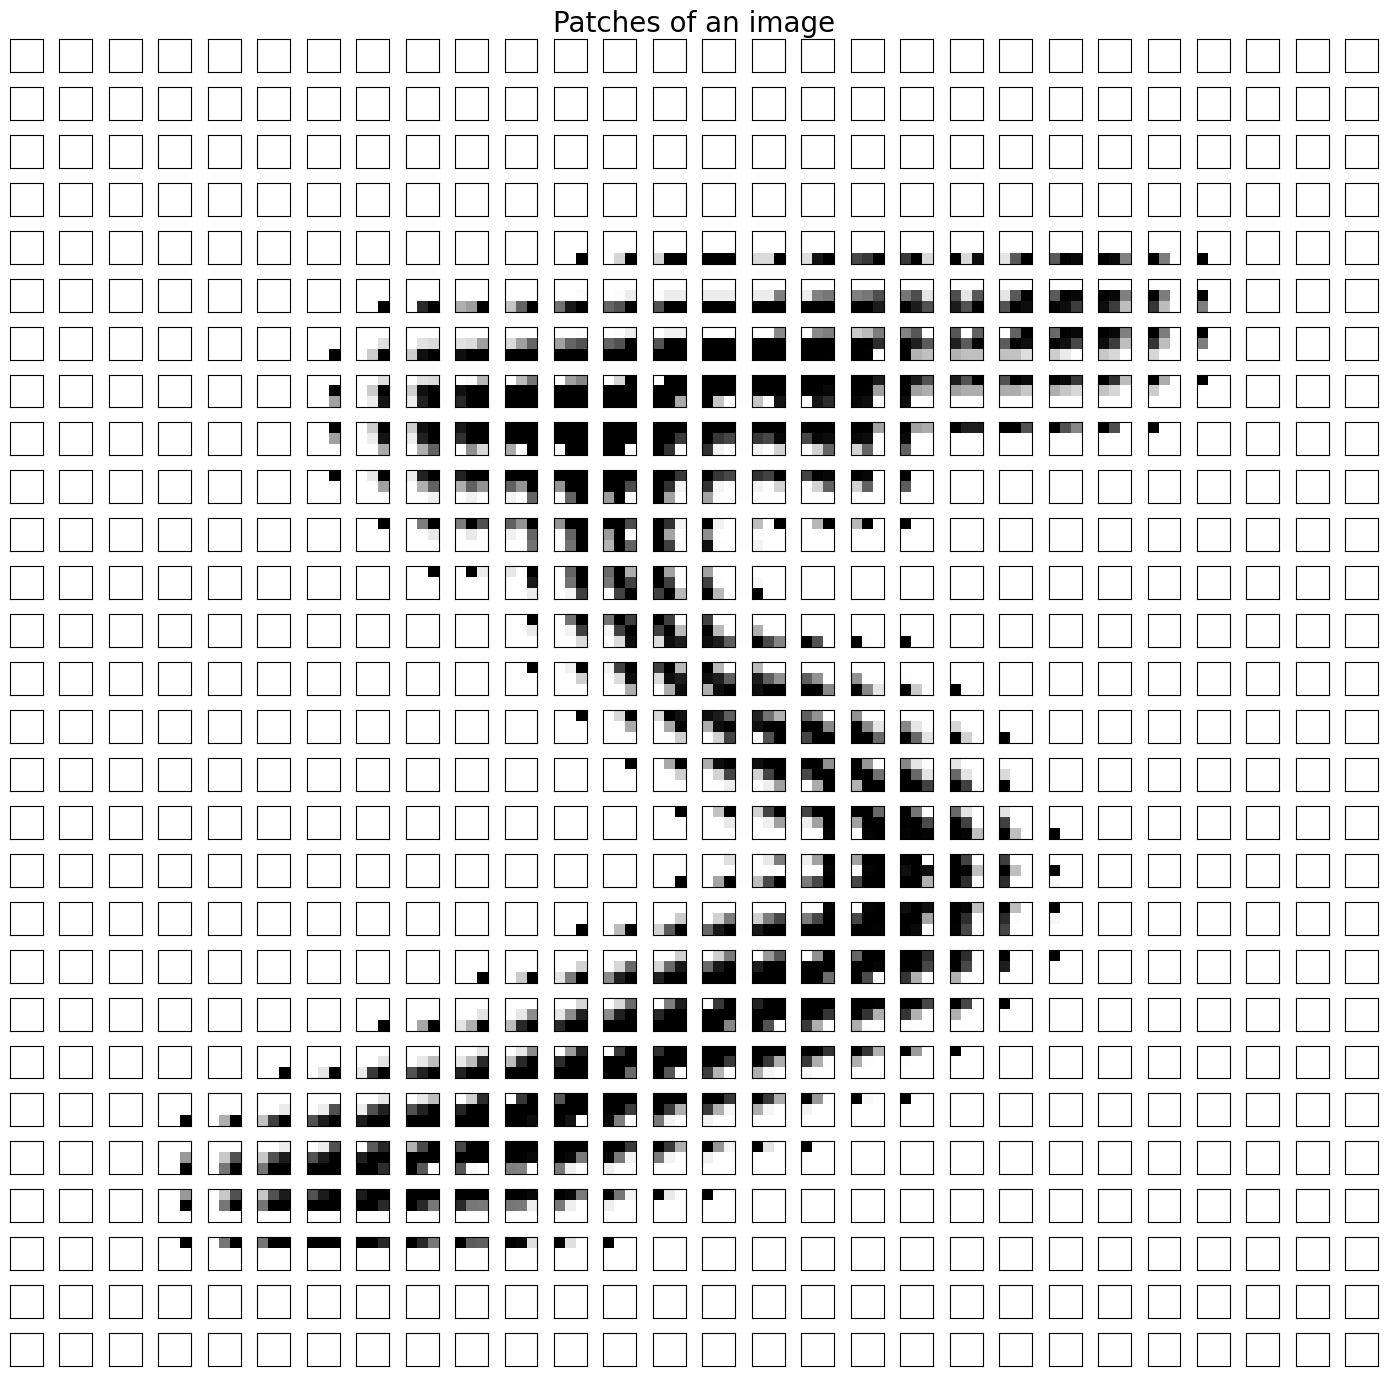

In [6]:
### visualize patches
image_patches = getPatches(x_train[0], patch_size, pad_size, stride)
num_row = 28
num_col = 28

fig, axes = plt.subplots(num_row, num_col, figsize=(0.5 * num_col, 0.5 * num_row))
for i in range(num_row * num_col):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(image_patches[i], cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Patches of an image", fontsize=20)
plt.tight_layout()
plt.show()

In [7]:
### extract all patches from a sample of images and store as points
sample_size = 10
image_samples = x_train[:sample_size]

# TODO: doesn't work for non NxN images
patches_per_image = image_samples.shape[1] * image_samples.shape[2] 
image_points = np.empty((sample_size * patches_per_image, patch_size * patch_size), dtype='uint8')

for i, image in enumerate(image_samples):
    image_patches = getPatches(image, patch_size, pad_size, stride)
    image_patches = image_patches.reshape(image_patches.shape[0], -1)

    start = i * patches_per_image
    end = (i + 1) * patches_per_image
    image_points[start:end] = image_patches

In [8]:
### data preprocessing for k-means

print('image points original:', image_points.shape, image_points.dtype)

# extract nonzero points
image_points = image_points[~np.all(image_points == 0, axis=1)]
print('image points nonzero:', image_points.shape, image_points.dtype)

# change from uint8 to np.float32
image_points = image_points.astype(np.float32)

# normalize values 
image_points_min = np.min(image_points)
image_points_max = np.max(image_points)

if image_points_max - image_points_min != 0:
    image_points = (image_points - image_points_min) / (image_points_max - image_points_min)
else:
    image_points = np.zeros_like(image_points)

print('image points normalized:', image_points.shape, image_points.dtype)

image points original: (7840, 9) uint8
image points nonzero: (2321, 9) uint8
image points normalized: (2321, 9) float32


In [46]:
### k-means: returns k number of centroids given a list of points
###    uses k-means++ for seeding 
###    & lloyd's algorithm for finding clusters

def k_means(points, n_clusters, max_iter=300, tol=0.0001):
    n_points, n_features = points.shape

    centroids = np.empty((n_clusters, n_features), dtype=points.dtype)
    labels = np.empty((n_points), dtype=np.int_)

    # k-means++ algorithm
    #   1. find first cluster uniformly at random
    # for each next cluster:
    #   1. calc distance from each point to nearest center
    #   2. chose next center at random (proportionally weighted to square of distances)
    
    # find first cluster uniformly at randome
    rng = np.random.default_rng()
    centroids[0] = rng.choice(points)
    
    # squared distance from each point to first centroid
    dist_squared = np.sum((points - centroids[0]) ** 2, axis=1).astype(np.float32)
    
    for i in range(1, n_clusters):
        # select random point to be next centroid
        # weighted proportionally to square distance
        probs = dist_squared / np.sum(dist_squared)
        idx = np.random.choice(n_points, p=probs)
        centroids[i] = points[idx] 

        # find min squared distance from each point to previous centroids
        new_dist_squared = np.sum((points - centroids[i]) ** 2, axis=1).astype(np.float32)
        dist_squared = np.minimum(dist_squared, new_dist_squared)
    
    # lloyds algorithm
    #   1. compute point to centroid dist for all points to each centroid
    #   2. assign each point to cluster of closest centroid
    #   3. compute average of points in each cluster to gain k new centroids
    #   4. repeat steps 1 to 3 until assignementds don't change or max iterations is reached

    for _ in range(max_iter):
        for i, p in enumerate(points):
            distances = np.min(np.linalg.norm(centroids - p, axis=1))
            
            labels[i] = np.argmin(distances)

        
        # min_distance = np.min(np.linalg.norm(centroids - points, axis=1))
            
    
    return centroids, labels

In [21]:
### generate 2d points for testing
mean_01 = np.array([0.0, 0.0])
cov_01 = np.array([[1, 0.3], [0.3, 1]])
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 100)

mean_02 = np.array([6.0, 7.0])
cov_02 = np.array([[1.5, 0.3], [0.3, 1]])
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 100)

mean_03 = np.array([7.0, -5.0])
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 100)

mean_04 = np.array([2.0, -7.0])
cov_04 = np.array([[1.2, 0.5], [0.5, 1.3]])
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 100)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)

# normalize points
data_min = np.min(data, axis=0)
data_max = np.max(data, axis=0)

range_ = data_max - data_min
range_[range_ == 0] = 1

data = (data - data_min) / range_# generate points for testing
mean_01 = np.array([0.0, 0.0])
cov_01 = np.array([[1, 0.3], [0.3, 1]])
dist_01 = np.random.multivariate_normal(mean_01, cov_01, 100)

mean_02 = np.array([6.0, 7.0])
cov_02 = np.array([[1.5, 0.3], [0.3, 1]])
dist_02 = np.random.multivariate_normal(mean_02, cov_02, 100)

mean_03 = np.array([7.0, -5.0])
dist_03 = np.random.multivariate_normal(mean_03, cov_01, 100)

mean_04 = np.array([2.0, -7.0])
cov_04 = np.array([[1.2, 0.5], [0.5, 1.3]])
dist_04 = np.random.multivariate_normal(mean_04, cov_01, 100)

data = np.vstack((dist_01, dist_02, dist_03, dist_04))
np.random.shuffle(data)

# normalize points
data_min = np.min(data, axis=0)
data_max = np.max(data, axis=0)

range_ = data_max - data_min
range_[range_ == 0] = 1

data = (data - data_min) / range_

[[0.29136537 0.54294425]
 [0.70319108 0.91990656]
 [0.7895166  0.23844573]]


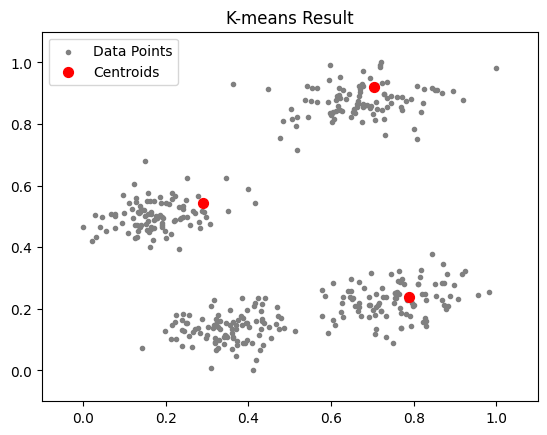

In [40]:
### k-means testing on 2d point space

# find centroids
centroids, labels = k_means(data, 3)
print(centroids)

# plot k-means result
plt.scatter(
    data[:, 0], data[:, 1],
    marker='.', color='gray', label='Data Points'
)
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    color='red', s=50, label='Centroids'
)
plt.title('K-means Result')
plt.legend()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.show()